# Belief in Supernatural Evil and Guns

In this assignment we will replicate a study of belief in supernatural evil and attitudes towards guns in the United States. 

---

> Chalkiopoulos Georgios, Electrical and Computer Engineer NTUA <br />
> Data Science postgraduate Student <br />
> gchalkiopoulos@aueb.gr

# Intro 
The study is:

Christopher G. Ellison, Benjamin Dowd-Arrow, Amy M. Burdette, Pablo E. Gonzalez, Margaret S. Kelley, Paul Froese,
"Peace through superior firepower: Belief in supernatural evil and attitudes toward gun policy in the United States", Social Science Research, Volume 99, 2021, [https://doi.org/10.1016/j.ssresearch.2021.102595](https://doi.org/10.1016/j.ssresearch.2021.102595).

# Imports

In [115]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pylab as pylab
import seaborn as sns
import pyreadstat
from time import time

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats.stats as stats
from statsmodels.formula.api import logit

from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler


import xgboost as xgb

from scipy.stats import sem

import re

from joblib import parallel_backend

from io import StringIO
from IPython.display import Image  
import pydotplus

# magic word for producing visualizations in notebook
%matplotlib inline

# Define plotting parameters
font_dict={'fontsize' : '12', 'fontweight': 'bold'}

# Obtain the Data

The data used in the paper is the "Baylor Religion Survey, Wave IV (2014)" and is downloaded from [thearda.com](https://www.thearda.com/Archive/Files/Downloads/BRS2014ED_DL2.asp).

We will use both the excel format file, but have also downloaded the SPSS file for reference, in case it is needed for any transformation.

* In order to read SPSS in Pandas, the pyreadstat library was needed.

In [116]:
# load the SPSS file
df_spss = pd.read_spss('./Baylor Religion Survey, Wave IV (2014).SAV')

# load the excel file and see the contents
df = pd.read_excel('./Instructional Dataset.XLSX')
df.head()

,MOTHERLODE_ID,PROJECT_ID,RESPONDENT_ID,METHOD_ID,METHOD_TYPE,PROJECT_NUMBER,CREATED_ON,PRACTICE,RESPONDENT_DATE,RESPONDENT_LANGUAGE,...,LIBCONR,PARTYIDR,CHILDSR,HRSWORKD,EDUCR,I_GENDER,I_EDUC,I_MARITAL,I_RELIGION,I_ATTEND
0,128170892,33370,01_000001_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,1.0,2.0,2.0,NaN,4.0,2.0,5.0,3.0,1.0,6.0
1,128170893,33370,01_000002_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,2.0,3.0,2.0,5.0,3.0,2.0,3.0,3.0,3.0,2.0
2,128170894,33370,01_000003_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,3.0,3.0,NaN,NaN,3.0,2.0,3.0,1.0,2.0,6.0
3,128170895,33370,01_000004_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,1.0,1.0,NaN,0.0,3.0,2.0,4.0,3.0,2.0,5.0
4,128170896,33370,01_000005_00000001,162048140_01,SCAN,162048140,3/26/2014,OTHER,1/24/2014,en-US,...,1.0,NaN,3.0,4.0,2.0,1.0,2.0,2.0,1.0,6.0


We only want to keep the columns of interest, being aligned with the study, which are the following:


* Dependent Variables

  * Ban on Semi-Auto Guns
  * Ban on High-Capacity Ammo Clips 
  * Banning Civilian Handguns
  * Support for Concealed Carry Laws 
  * More Armed Security at Schools 
  * More Teachers/Faculty having Guns 
  * More Gun Safety Programs 
  * Expanded Mental Health Screening
  
* Independept Variables
 
   * Religious Variables
     * Attendance
     * Bible (Human Error, History and Fables) 
     * Biblical Inerrancy
     * Biblical Literalism
     
  * Religious Affiliation
    * Conservative Protestant 
    * Mainline Protestant 
    * Black Protestant 
    * Catholic
    * Other
    * No Affiliation
  * Political Ideology
  * Age
  * Sex
    * Female
    * Male
  * Race
    * White
    * Hispanic
    * African American/Black 
    * Other
  * Education
    * Less Than High School 
    * High School or Equivalent 
    * Some College
    * College Degree 
    * Post-graduate Degree 
  * Household Income
  * Marital Status
    * Not Partnered/Single 
    * Married/Cohabitating
  * Children
    * No kids under 18 in home 
    * Kids under 18 in home
  * Area Demographics
    * Small Town/Rural
    * Urban Area
  * Region
    * South
    * Other Region

Using the "Codebook with variable descriptions.txt" (downloaded form the same source as the data) we find the corresponding column names, and only keep those.

In [117]:
columns_needed = ['Q73A', 'Q73E', 'Q73G', 'Q73H', 'Q73C', 'Q73F', 'Q73B', 'Q73D', # Dependent Variables
                'Q23A', 'Q23C', 'Q23G', # supernatural
                'Q23A', 'Q23C', 'Q23G', # supernatural
                'Q4', 'Q17',        # Religious Variables
                'RELTRAD',          # Religious Affiliation
                'Q31',              # Political Ideology
                'AGE', 'AGE_VALID', # Age
                'Q77',              # Sex
                'Q88A', 'Q89', 'Q88B', 'Q88F',  # Race
                'Q90',            # Education
                'Q95',            # Household Income
                'Q51A',            # Marital Status
                'Q93', 'Q93_NONE', # Children
                'Q80',            # Area Demographics
                'STATE'            # Region
                ]

# drop unwanted columns
df.drop(columns=[col for col in df if col not in columns_needed], inplace=True)

* We will rename the columns to represent the actual names of each variable

In [118]:
# rename dict mapping
rename_columns = {
                'Q73A' : 'Semi-Auto Weapons Ban', 'Q73E' : 'High-Capacity Magazine Ban', 'Q73G' : 'Civilian Hand Gun Possession Ban', 
                'Q73H' : 'Support for Concealed Carry', 'Q73C' : 'More Armed Security at Schools', 'Q73F' : 'More Teachers/Faculty with Guns', 
                'Q73B' : 'Required Gun Safety Programs', 'Q73D' : 'Expanded Mental Health Screening', # Dependent Variables
                'Q23A' : 'Devil', 'Q23C' : 'Hell', 'Q23G' : 'Demons', # supernatural
                'Q4' : 'Attendance', 'Q17' : 'Biblical',        # Religious Variables
                'RELTRAD' : 'Religious Affiliation',          # Religious Affiliation
                'Q31' : 'Political Ideology',              # Political Ideology
                'AGE'  : 'Age',             # Age
                'Q77' : 'Sex',              # Sex
                'Q88A' : 'White' , 'Q89' : 'Hispanic', 'Q88B' : 'African American/Black', 'Q88F' : 'Other',  # Race
                'Q90' : 'Education',            # Education
                'Q95' : 'Income',            # Household Income
                'Q51A' : 'Marital Status',            # Marital Status
                'Q93' : 'Kids', 'Q93_NONE' : 'Kids_None', # Children
                'Q80' : 'Residence',            # Area Demographics
                'STATE' : 'State'           # Region
                
}

# Rename dict
df.rename(rename_columns, axis=1, inplace=True)

In [119]:
# re-order based on study order
order = ['Semi-Auto Weapons Ban', 'High-Capacity Magazine Ban', 'Civilian Hand Gun Possession Ban', 'Support for Concealed Carry',
        'More Armed Security at Schools', 'More Teachers/Faculty with Guns', 'Required Gun Safety Programs', 'Expanded Mental Health Screening',
        'Devil', 'Hell', 'Demons',
        'Attendance', 
        'Biblical', 
        'Religious Affiliation',
        'Political Ideology',
        'White' , 'Hispanic', 'African American/Black', 'Other',
        'Sex',
        'Education',
        'Age',
        'Income',
        'Marital Status', 
        'Kids', 'Kids_None', 
        'Residence',
        'State'
        ]
df = df[order]

In [120]:
# apply the same transformations to the spss format the spss df
df_spss.drop(columns=[col for col in df_spss if col not in columns_needed], inplace=True)
df_spss.rename(rename_columns, axis=1, inplace=True)
df_spss = df_spss[order]

In [121]:
df.shape

(1572, 28)

In [122]:
df.head(3)

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening,Devil,Hell,...,Other,Sex,Education,Age,Income,Marital Status,Kids,Kids_None,Residence,State
0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,...,NaN,2.0,6.0,85,2.0,5.0,NaN,1.0,4.0,TX
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,...,NaN,2.0,4.0,0,1.0,5.0,2.0,NaN,1.0,TX
2,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,3.0,2.0,...,2.0,2.0,4.0,67,3.0,1.0,NaN,NaN,3.0,ND


In [123]:
df.describe()

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening,Devil,Hell,...,African American/Black,Other,Sex,Education,Age,Income,Marital Status,Kids,Kids_None,Residence
count,1502.000000,1502.000000,1501.000000,1502.000000,1510.000000,1504.000000,1515.000000,1512.000000,1504.000000,1499.000000,...,822.000000,672.00000,1536.000000,1501.000000,1572.000000,1467.000000,1554.000000,542.000000,704.0,1520.000000
mean,1.370839,1.328895,1.709527,1.442077,1.378146,1.705452,1.072607,1.091931,3.149601,3.088726,...,1.782238,1.91369,1.578776,5.006662,49.162214,4.151329,2.646718,1.326568,1.0,2.355921
std,0.483190,0.469968,0.454132,0.496799,0.485085,0.455991,0.259576,0.289024,1.108048,1.114655,...,0.412976,0.28103,0.493916,1.602900,21.018613,1.707939,1.591398,1.097129,0.0,1.006381
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,...,2.000000,2.00000,1.000000,4.000000,35.000000,3.000000,2.000000,0.000000,1.0,1.000000
50%,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,4.000000,4.000000,...,2.000000,2.00000,2.000000,5.000000,52.000000,5.000000,2.000000,1.000000,1.0,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,4.000000,4.000000,...,2.000000,2.00000,2.000000,6.000000,64.000000,5.000000,3.000000,2.000000,1.0,3.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,4.000000,...,2.000000,2.00000,2.000000,7.000000,99.000000,7.000000,6.000000,6.000000,1.0,4.000000


In [124]:
for i, col in enumerate(df.columns):
    print(f"{i:2d} {col:36s} {df[col].dtypes}")


 0 Semi-Auto Weapons Ban                float64
 1 High-Capacity Magazine Ban           float64
 2 Civilian Hand Gun Possession Ban     float64
 3 Support for Concealed Carry          float64
 4 More Armed Security at Schools       float64
 5 More Teachers/Faculty with Guns      float64
 6 Required Gun Safety Programs         float64
 7 Expanded Mental Health Screening     float64
 8 Devil                                float64
 9 Hell                                 float64
10 Demons                               float64
11 Attendance                           float64
12 Biblical                             float64
13 Religious Affiliation                float64
14 Political Ideology                   float64
15 White                                float64
16 Hispanic                             float64
17 African American/Black               float64
18 Other                                float64
19 Sex                                  float64
20 Education                            

<br><br><br><br><br><br><br>

# Section 1: Belief in Supernatural Evil Metric

In order to measure the belief in supernatural evil, we will use the answers to three questions asked by the participants in the survey:

* Whether the respondent believes in the devil.

* Whether the respondent believes in hell.

* Whether the respondent believes in demons.

We will investigate how the answers to these three questions can be combined to a single metric.

Based on the study approach, the three metrics were combined into one variable using the average of the values. This approach makes sense and we will evaluate this through linear regression. 

Moreover we will use PCA with one component to see if we get better results.

In [125]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca1, pca2):
    '''
    Function to plot the PCA results for a given component
    INPUT: two pcas in which fit_transform has been applied
    OUTPUT: side by side view of Explained Variance Per Principal Component and returns the explained variance sum
    '''
    fig = plt.figure(figsize = (15,7))
    ax1 = fig.add_subplot(1, 2, 1)
    sum_plot1 = []
    for i, comp in enumerate(pca1.explained_variance_ratio_):
        try:
            sum_plot1.append(sum_plot1[i-1]+comp)
        except:
            sum_plot1.append(comp)

    ax1.plot(sum_plot1)
    ax1.bar(np.arange(0,len(pca1.explained_variance_ratio_)),pca1.explained_variance_ratio_)
    ax1.set_xlabel("Principal Component")
    ax1.set_ylabel("Variance Explained (%)")
    ax1.set_title('Explained Variance Per Principal Component (One component)')
    ax1.set_yticks(np.arange(0 , 1.1 , 0.2), (0, 20, 40, 60, 80, 100))

    ax2 = fig.add_subplot(1, 2, 2)
    sum_plot2 = []
    for i, comp in enumerate(pca2.explained_variance_ratio_):
        try:
            sum_plot2.append(sum_plot2[i-1]+comp)
        except:
            sum_plot2.append(comp)

    ax2.plot(sum_plot2)
    ax2.bar(np.arange(0,len(pca2.explained_variance_ratio_)),pca2.explained_variance_ratio_)
    ax2.set_xlabel("Principal Component")
    ax2.set_ylabel("Variance Explained (%)")
    ax2.set_title('Explained Variance Per Principal Component (Three components)')
    ax2.set_yticks(np.arange(0 , 1.1 , 0.2), (0, 20, 40, 60, 80, 100))

    fig.suptitle("One vs Three Explained Variance Per Principal Component", \
            fontsize = 16, y = 1.03)
    fig.tight_layout()
    

    return sum_plot1, sum_plot2

In [126]:
# Apply PCA to the data.
supernatural = df[['Devil', 'Hell', 'Demons']].dropna()
pca = PCA(1)
X_pca = pca.fit_transform(supernatural)

                            OLS Regression Results                            
Dep. Variable:                    pca   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.004e+31
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        23:53:44   Log-Likelihood:                 45064.
No. Observations:                1474   AIC:                        -9.012e+04
Df Residuals:                    1470   BIC:                        -9.010e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3359   1.03e-15   5.19e+15      0.0

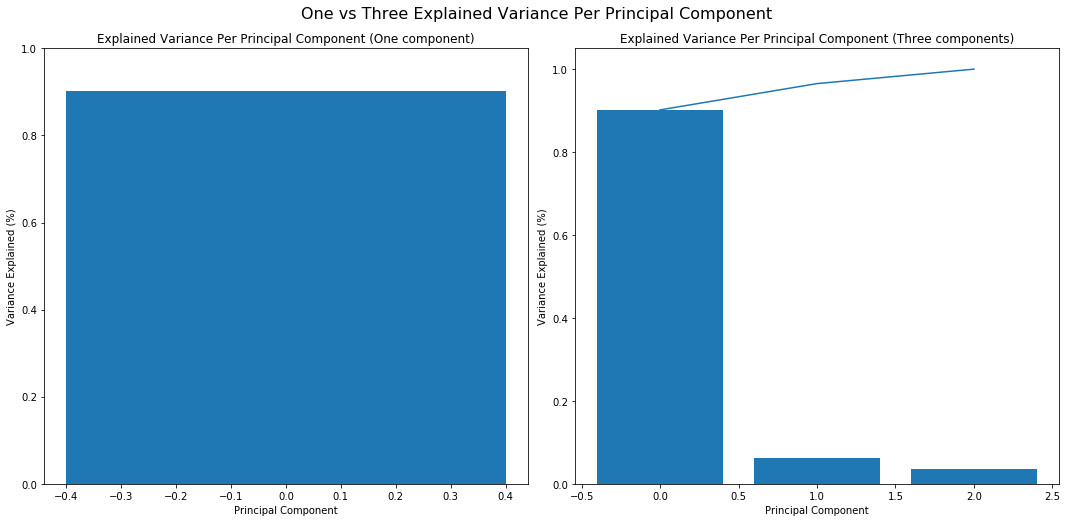

In [127]:
# Apply PCA to the data.
pca1, pca2 = PCA(1), PCA(3)
X_pca1, X_pca2 = pca1.fit_transform(supernatural), pca2.fit_transform(supernatural)

# Check LR results
supernatural['pca'] = X_pca1
mod_ml = smf.ols("pca ~ Devil + Hell + Demons", data=supernatural)
boston_res_ml = mod_ml.fit()
print(boston_res_ml.summary())


#plot the results
total_variance_list = scree_plot(pca1, pca2)

In [128]:
# ChecK OLS results for the average of the three values
supernatural['study'] = supernatural[['Devil', 'Hell', 'Demons']].sum(axis=1)/3
mod_ml = smf.ols("study ~ Devil + Hell + Demons", data=supernatural)
boston_res_ml = mod_ml.fit()
print(boston_res_ml.summary())

                            OLS Regression Results                            
Dep. Variable:                  study   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.894e+31
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        23:53:44   Log-Likelihood:                 46653.
No. Observations:                1474   AIC:                        -9.330e+04
Df Residuals:                    1470   BIC:                        -9.328e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.144e-14    3.5e-16     32.717      0.0

Based on the above results we may see that both the PCA and the Averaging methods produce excellent results. Moreover, the PCA explains a great percentage of the three variables (around 90%). In order to better be aligned with the study, and given that the two approaches are equivalent we will proceed with using the Average of the values for the "Supernatural" variable.

In [129]:
df[['Devil', 'Hell', 'Demons']] = df[['Devil', 'Hell', 'Demons']].apply(lambda x: x.fillna(x.mean()),axis=0)

In [130]:
df['Supernatural'] = df[['Devil', 'Hell', 'Demons']].sum(axis=1)/3
df['Supernatural'].describe()

count    1572.000000
mean        3.084804
std         1.026956
min         1.000000
25%         2.333333
50%         3.333333
75%         4.000000
max         4.000000
Name: Supernatural, dtype: float64

In [131]:
# Fill NA values with mean and calculate the avg in a new columns
df[['Devil', 'Hell', 'Demons']] = df[['Devil', 'Hell', 'Demons']].apply(lambda x: x.fillna(x.mean()),axis=0)
df['Supernatural'] = df[['Devil', 'Hell', 'Demons']].sum(axis=1)/3

# drop the previous (unwanted) columns
df.drop(['Devil', 'Hell', 'Demons'], axis=1, inplace=True)

# Section 2: Variables Selection

Apart from the belief in supernatural evil metric, we will use several other variables to control our estimates. These variables mentioned previously, and already pre-processed, in some extend. We will now finalize the pre-processing, by running some descriptive statistics, handle missing values and, finally, encode them with dummy variables where needed. 

In the end, we will use the variables as shown in Table 1 and Table 2 of the original publication.

##### Missing Data Evaluation

We will now proceed with clearing the data from missing values and compare the data we have to appendix A.
* Regarding the dependent variables, we will drop any rows with missing data

In [132]:
for i, col in enumerate(df.columns):
    print(f"{i:2d} {col:36s} {df[col].dtypes}")

 0 Semi-Auto Weapons Ban                float64
 1 High-Capacity Magazine Ban           float64
 2 Civilian Hand Gun Possession Ban     float64
 3 Support for Concealed Carry          float64
 4 More Armed Security at Schools       float64
 5 More Teachers/Faculty with Guns      float64
 6 Required Gun Safety Programs         float64
 7 Expanded Mental Health Screening     float64
 8 Attendance                           float64
 9 Biblical                             float64
10 Religious Affiliation                float64
11 Political Ideology                   float64
12 White                                float64
13 Hispanic                             float64
14 African American/Black               float64
15 Other                                float64
16 Sex                                  float64
17 Education                            float64
18 Age                                  int64
19 Income                               float64
20 Marital Status                       fl

In [133]:
# fill NA values with -99 to drop later
c = df.columns[0:8] 
df[c] = df[c].fillna(-99)
df.shape

(1572, 26)

In [134]:
# Perform an assessment of how much missing data there is in each column of the
# dataset. 
def return_missing_data(df):
    total_rows = df.shape[0]
    missing_data = dict(zip(df.columns,df.isnull().sum()))
    # ordered_missing_data = dict(sorted(missing_data.items(), key= lambda x: x[1], reverse=True))
    for key, value in missing_data.items():
        if value > 0:
            print("Missing Data in column {:80} : {:8} ({:2.2f}%)".format(key, value, value/total_rows*100))
return_missing_data(df)

Missing Data in column Attendance                                                                       :       16 (1.02%)
Missing Data in column Biblical                                                                         :      167 (10.62%)
Missing Data in column Religious Affiliation                                                            :       91 (5.79%)
Missing Data in column Political Ideology                                                               :       51 (3.24%)
Missing Data in column White                                                                            :      269 (17.11%)
Missing Data in column Hispanic                                                                         :      683 (43.45%)
Missing Data in column African American/Black                                                           :      750 (47.71%)
Missing Data in column Other                                                                            :      900 (57.25%)
Missing Dat

In [135]:
df.iloc[:,8:-1].describe()

,Attendance,Biblical,Religious Affiliation,Political Ideology,White,Hispanic,African American/Black,Other,Sex,Education,Age,Income,Marital Status,Kids,Kids_None,Residence
count,1556.000000,1405.000000,1481.000000,1521.000000,1303.000000,889.000000,822.000000,672.00000,1536.000000,1501.000000,1572.000000,1467.000000,1554.000000,542.000000,704.0,1520.000000
mean,3.676735,2.389324,3.312627,3.800789,1.099770,1.397075,1.782238,1.91369,1.578776,5.006662,49.162214,4.151329,2.646718,1.326568,1.0,2.355921
std,2.932510,1.131031,2.096692,1.554416,0.299808,0.982294,0.412976,0.28103,0.493916,1.602900,21.018613,1.707939,1.591398,1.097129,0.0,1.006381
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.000000
25%,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.00000,1.000000,4.000000,35.000000,3.000000,2.000000,0.000000,1.0,1.000000
50%,3.000000,2.000000,3.000000,4.000000,1.000000,1.000000,2.000000,2.00000,2.000000,5.000000,52.000000,5.000000,2.000000,1.000000,1.0,2.000000
75%,7.000000,4.000000,4.000000,5.000000,1.000000,1.000000,2.000000,2.00000,2.000000,6.000000,64.000000,5.000000,3.000000,2.000000,1.0,3.000000
max,8.000000,4.000000,7.000000,7.000000,2.000000,5.000000,2.000000,2.00000,2.000000,7.000000,99.000000,7.000000,6.000000,6.000000,1.0,4.000000


In [136]:
# Fill continious variables with Mean value
df[['Attendance', 'Biblical', 'Religious Affiliation', 'Political Ideology', 'Education', 'Age', 'Income']] = \
    df[['Attendance', 'Biblical', 'Religious Affiliation', 'Political Ideology', 'Education', 'Age', 'Income']].apply(lambda x: x.fillna(x.mode()[0]),axis=0)

* There are 28 columns of which values need to be aligned to match the study. (Age_valid is not calculated as one)

We will split the analysis based on each category and use the [Complete codebook with frequencies and percentages.](https://osf.io/m3u85/download) as a reference to translate the integer values to actual answers.

**1.5. Dependent variables: gun policy attitudes** <br>
&emsp;This conerns the first 8 columns. Based on the study the values used were set to 1 for favor and 0 for oppose, but here we see that we have 1 and 2 for favor and oppose respectively. For this reason, we will subtract 1, to have the desired values 0 and 1.

In [137]:
# See original dependent variables format
df.iloc[:,0:8].head(3)

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening
0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
1,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0


In [138]:
# apply function to map 0 and 1 to dependent variables
c = df.columns[0:8] 
for col in c:
    df[col] = df[col].apply(lambda x: x % 2 if x != -99 else x)

df.iloc[:,0:8]

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
1567,-99.0,1.0,-99.0,0.0,1.0,-99.0,-99.0,1.0
1568,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1569,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
1570,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


**1.6 Religious variables** <br>
Quoring the study:
"*[...] belief in supernatural evil, is based on a three-item index [...] Response categories for each item were as
follows: 4 = absolutely, 3 = probably, 2 = probably not, and 1 = definitely not.*"

Moreover:<br>
"* Finally, religiosity is measured using
responses to a single item on the frequency of religious attendance, which ranges from “never” (=0) to “several times a week” (=8).*"

and:<br>
"*We use dummy variables to
identify persons who embrace one of the two most conservative positions: (a) “The Bible means exactly what it says. It should be taken
literally, word-for-word on all subjects” (1 = literalism) or (b) “The Bible is perfectly true, but it should not be taken literally, word-forword.
We must interpret its meaning” (1 = inerrancy). Biblical literalists (22.9% unweighted) and biblical inerrantists (33.8% unweighted)
are compared with the reference group (43.3% unweighted), which consists of respondents who believe that the Bible
contains some human error, or who believe the Bible is an ancient book of history and legends.*"<br>
47) Q17<br>
Which one statement comes closest to your personal beliefs about the Bible? (Please mark only one box.)<br>
RANGE: 1 to 4<br>
	N	Mean	Std. Deviation<br>
Total	1405	2.389	1.131<br>
1) The Bible means exactly what it says. It should be taken literally, word-for-word, on all subjects.	355	25.3
2) The Bible is perfectly true, but it should not be taken literally, word-for-word. We must interpret its meaning.	524	37.3
3) The Bible contains some human error.	150	10.7
4) The Bible is an ancient book of history and legends.	376	26.8<br>
Missing	167

Finally:<br>
"*First, we
measure denominational affiliation using a variant of the well-established RELTRAD coding scheme (Steensland et al., 2000),
including dummy variables for the following categories (a) conservative (i.e., fundamentalist, evangelical, and charismatic): Protestant;
(b) mainline Protestant; (c) black Protestant; (d) Catholic; and (e) other religion (including Judaism, Islam, other non-Christian
world religions, and various smaller minority faiths).*"<br>
Where:<br>

77) RELTRAD<br>
Religious Tradition<br>
RANGE: 1 to 7<br>
	N	Mean	Std. Deviation <br>
Total	1481	3.313	2.097<br>
1) Evangelical Protestant	421	28.4
2) Mainline Protestant	250	16.9
3) Black Protestant	106	7.2
4) Catholic	369	24.9
5) Jewish	33	2.2
6) Other	88	5.9
7) No Affiliation	214	14.4

As seen below we need to re-map the "Biblical" and "Religious Affiliation" columns to better reflect the results.

In [139]:
# rest of variables
df.iloc[:,8:14].head(3)

,Attendance,Biblical,Religious Affiliation,Political Ideology,White,Hispanic
0,8.0,1.0,1.0,1.0,NaN,1.0
1,1.0,1.0,3.0,4.0,2.0,NaN
2,7.0,2.0,2.0,6.0,1.0,1.0


In [140]:
# dictionary for Biblical re-mapping
bibl = {1 : 'Biblical Literalism', 2 : 'Biblical Inerrancy', 3 : 'Bible (Human Error, History and Fables)', 4: 'Bible (Human Error, History and Fables)'}
df['Biblical'] = df['Biblical'].map(bibl)

# dictionary for Religious Affiliation re-mapping
df['Religious Affiliation'] = df['Religious Affiliation'].apply(lambda x: 5 if x==6 else x)
affiliation = {1 : 'Conservative Protestant', 2 : 'Mainline Protestant', 3 : 'Black Protestant', 4: 'Catholic', 5: 'Other Religion', 7:'No Affiliation'}
df['Religious Affiliation'] = df['Religious Affiliation'].map(affiliation)

df[['Religious Affiliation', 'Biblical']].head(3)

,Religious Affiliation,Biblical
0,Conservative Protestant,Biblical Literalism
1,Black Protestant,Biblical Literalism
2,Mainline Protestant,Biblical Inerrancy


**1.7. Other variables**<br>

"*Multivariate analyses also control for background variables that are known correlates of gun ownership and policy preference
(Dowd-Arrow et al., 2019; Hill et al., 2020a; Yamane 2016), including: gender (1 = female, 0 = male); race/ethnicity (1 = non-Hispanic
Black, 1 = Hispanic, 1 = other minority, 0 = non-Hispanic white); age (in years); level of education (1 = less than high school,
1 = some college, but no degree, 1 = college graduate, 1 = postgraduate education, 0 = high school degree or equivalent); household
income (in dollars, categorical ranging from 1 = $10K or less to 7 = $150K or more); marital status (1 = married or cohabiting, 0 = all
others); children under 18 residing in the home (1 = yes, 0 = no); type of community of residence (1 = urban area, 0 = small
town/rural); region of residence (1 = South, 0 = all others). [...] Thus, in our models, we incorporate controls for political ideology
(1 = extremely conservative to 7 = extremely liberal).*"

In [141]:
# see columns to adjust
df.iloc[:,12:].head(3)

,White,Hispanic,African American/Black,Other,Sex,Education,Age,Income,Marital Status,Kids,Kids_None,Residence,State,Supernatural
0,NaN,1.0,NaN,NaN,2.0,6.0,85,2.0,5.0,NaN,1.0,4.0,TX,4.000000
1,2.0,NaN,1.0,NaN,2.0,4.0,0,1.0,5.0,2.0,NaN,1.0,TX,4.000000
2,1.0,1.0,2.0,2.0,2.0,4.0,67,3.0,1.0,NaN,NaN,3.0,ND,2.333333


In [142]:
# Race adjustment
df[['White', 'African American/Black', 'Other']] = df[['White', 'African American/Black', 'Other']].apply(lambda x: x % 2)
df['Hispanic'] = df['Hispanic'].apply(lambda x: 1.0 if x > 1.0 else x-1)

# Gender adjustment
df['Female'] = df['Sex'].apply(lambda x: x-1)

# Education adjustment
edu = {
    1 : 'Less Than HS',
    2 : 'Less Than HS',
    3 : 'High school graduate',
    4 : 'Some college',
    5 : 'Some college',
    6 : 'College Graduate',
    7 : 'Postgraduate'
}
df['Education'] = df['Education'].map(edu)

# Marital Status adjustment
status = {
    1 : 0,
    2 : 1,
    3 : 1,
    4 : 0,
    5 : 0,
    6 : 0
}
df['Married'] = df['Marital Status'].map(status)

# kids Status adjustment
df['Children'] = df['Kids'].apply(lambda x: 1 if x > 0 else (0 if pd.notnull(x) else x))
df['Children'] = df[['Children', 'Kids_None']].apply(lambda x: 0 if x['Kids_None'] == 1 else x['Children'], axis=1)
df['Children'].fillna(np.random.randint(2)).describe()

# Residence adjustment
resid = {
    1 : 1,
    2 : 1,
    3 : 0,
    4 : 0
}
df['Urban'] = df['Residence'].map(resid)

# State adjustment
south_states = ['MD', 'DE', 'VA', 'WV', 'KY', 'TN', 'NC', 'SC', 'FL', 'GA', 'AL', 'MS', 'LA', 'AK', 'TX', 'OK']
df['South'] = df['State'].apply(lambda x: 1 if x in south_states else (0 if pd.notnull(x) else np.nan()))

# drop unused columns
df.drop(['State', 'Marital Status', 'Sex', 'Kids', 'Kids_None'], axis=1, inplace=True)

In [143]:
# adjusted
df.iloc[:,12:].head(3)

,White,Hispanic,African American/Black,Other,Education,Age,Income,Residence,Supernatural,Female,Married,Children,Urban,South
0,NaN,0.0,NaN,NaN,College Graduate,85,2.0,4.0,4.000000,1.0,0.0,0.0,0.0,1
1,0.0,NaN,1.0,NaN,Some college,0,1.0,1.0,4.000000,1.0,0.0,1.0,1.0,1
2,1.0,0.0,0.0,0.0,Some college,67,3.0,3.0,2.333333,1.0,0.0,NaN,0.0,0


* Some valirables need to be combined into one columns in order to make a correct assesment of the missing data

In [144]:
# Race one column adjustemnt
def return_race(row):
    if row['Hispanic'] == 1:
        return 'Hispanic'
    elif row['Other'] == 1:
        return 'Other Race'
    elif row['African American/Black'] == 1: 
        return 'Non-Hispanic Black'
    elif row['White'] == 1:
        return 'White'
    else:
        return np.nan
df['Race'] = df.apply(return_race, axis =1)
df.drop(['White','Hispanic','African American/Black','Other'], axis=1, inplace=True)

In [145]:
# Fill continious variables with Mode value
df[['Female', 'Urban', 'Children', 'South', 'Race', 'Married']] = df[['Female', 'Urban', 'Children', 'South', 'Race', 'Married']].apply(lambda x: x.fillna(x.mode()[0]),axis=0)

In [146]:
df.describe()

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening,Attendance,Political Ideology,Age,Income,Residence,Supernatural,Female,Married,Children,Urban,South
count,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1520.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000
mean,-3.807252,-3.767176,-4.194020,-3.875318,-3.307252,-4.000636,-2.695929,-2.905216,3.639313,3.807252,49.162214,4.208015,2.355921,3.084804,0.588422,0.557888,0.253817,0.543257,0.377863
std,20.562253,20.570612,20.630665,20.547868,19.402379,20.211344,18.687634,19.150728,2.940800,1.529385,21.018613,1.663434,1.006381,1.026956,0.492276,0.496796,0.435332,0.498284,0.485007
min,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,35.000000,3.000000,1.000000,2.333333,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,3.000000,4.000000,52.000000,5.000000,2.000000,3.333333,1.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,64.000000,5.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,7.000000,99.000000,7.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Re-Encode Categorical Features - Dummy Variables

We will now use the get_dummies dummies command to convert the variables to dummy ones. Since we already have prepared the data we will only apply this where it's needed, for the rest we will rename the columns for a last time.

To have better control we will use get dummies and then drop the columns we don't need.

In [147]:
# one hot encoding 
df = pd.get_dummies(df, prefix='', prefix_sep='')
df.head(3)

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening,Attendance,Political Ideology,...,Other Religion,College Graduate,High school graduate,Less Than HS,Postgraduate,Some college,Hispanic,Non-Hispanic Black,Other Race,White
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,...,0,1,0,0,0,0,0,0,0,1
1,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.0,4.0,...,0,0,0,0,0,1,0,1,0,0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,6.0,...,0,0,0,0,0,1,0,0,0,1


In [148]:
# drop columns that are not needed.
not_needed_col = [ 'Bible (Human Error, History and Fables)', 'No Affiliation', 'White', 'High school graduate']
df.drop([col for col in not_needed_col], inplace=True, axis=1)
df.columns

# re-order and re-name
order = ['Semi-Auto Weapons Ban', 'High-Capacity Magazine Ban',
       'Civilian Hand Gun Possession Ban', 'Support for Concealed Carry',
       'More Armed Security at Schools', 'More Teachers/Faculty with Guns',
       'Required Gun Safety Programs', 'Expanded Mental Health Screening',
       'Supernatural', 'Attendance', 'Biblical Inerrancy', 'Biblical Literalism',
       'Mainline Protestant', 'Black Protestant', 'Conservative Protestant', 'Catholic', 'Other Religion',
       'Political Ideology', 
       'Non-Hispanic Black', 'Hispanic', 'Other Race',
       'Female', 
       'Less Than HS', 'Some college', 'College Graduate', 'Postgraduate',
       'Age',
       'Income', 'Married', 'Children', 'Urban', 'South',
       ]
df = df[order]

* We ended up with the same names as the ones in the study.

In [149]:
df.columns

Index(['Semi-Auto Weapons Ban', 'High-Capacity Magazine Ban',
       'Civilian Hand Gun Possession Ban', 'Support for Concealed Carry',
       'More Armed Security at Schools', 'More Teachers/Faculty with Guns',
       'Required Gun Safety Programs', 'Expanded Mental Health Screening',
       'Supernatural', 'Attendance', 'Biblical Inerrancy',
       'Biblical Literalism', 'Mainline Protestant', 'Black Protestant',
       'Conservative Protestant', 'Catholic', 'Other Religion',
       'Political Ideology', 'Non-Hispanic Black', 'Hispanic', 'Other Race',
       'Female', 'Less Than HS', 'Some college', 'College Graduate',
       'Postgraduate', 'Age', 'Income', 'Married', 'Children', 'Urban',
       'South'],
      dtype='object')

In [150]:
df.head(3)

,Semi-Auto Weapons Ban,High-Capacity Magazine Ban,Civilian Hand Gun Possession Ban,Support for Concealed Carry,More Armed Security at Schools,More Teachers/Faculty with Guns,Required Gun Safety Programs,Expanded Mental Health Screening,Supernatural,Attendance,...,Less Than HS,Some college,College Graduate,Postgraduate,Age,Income,Married,Children,Urban,South
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.000000,8.0,...,0,0,1,0,85,2.0,0.0,0.0,0.0,1
1,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,4.000000,1.0,...,0,1,0,0,0,1.0,0.0,1.0,1.0,1
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.333333,7.0,...,0,1,0,0,67,3.0,0.0,0.0,0.0,0


<br><br><br><br>

# Section 3: Predict Support for Various Gun Policies

We will proceed to predict support for various gun policies from the metric of supernatural evil, controlling for background variables.

The gun policies are:

* Semi-Auto Weapons Ban

* High-Capacity Magazine Ban

* Cilivian Hand Gun Possession Ban

* Support for Concealed Carry

* More Armed Security at Schools

* More Teachers / Faculty with Guns

* Required Gun Safety Programs

* Expanded Mental Health Screening

We will discuss the effects and the strengths of the various predictors (metric of supernatural evil, which is our focal variable, plus any others that we see significant). We will cross-check with Table 1 and Table 2 of the original publication.

The research was reported in *The Economist*, on November 6, 2021, under the title "Belief in supernatural evil is a strong predictor of pro-gun beliefs" (United States section), available at https://www.economist.com/united-states/2021/11/06/belief-in-supernatural-evil-is-a-strong-predictor-of-pro-gun-beliefs (you may access it after a free registration).

In [151]:
# make columns pythonic
df = df.rename(columns=lambda x: re.sub('[-/ ]', '_', x)) 
df.columns

Index(['Semi_Auto_Weapons_Ban', 'High_Capacity_Magazine_Ban',
       'Civilian_Hand_Gun_Possession_Ban', 'Support_for_Concealed_Carry',
       'More_Armed_Security_at_Schools', 'More_Teachers_Faculty_with_Guns',
       'Required_Gun_Safety_Programs', 'Expanded_Mental_Health_Screening',
       'Supernatural', 'Attendance', 'Biblical_Inerrancy',
       'Biblical_Literalism', 'Mainline_Protestant', 'Black_Protestant',
       'Conservative_Protestant', 'Catholic', 'Other_Religion',
       'Political_Ideology', 'Non_Hispanic_Black', 'Hispanic', 'Other_Race',
       'Female', 'Less_Than_HS', 'Some_college', 'College_Graduate',
       'Postgraduate', 'Age', 'Income', 'Married', 'Children', 'Urban',
       'South'],
      dtype='object')

In [152]:
dependent_col = list(df.columns[0:8]) 
model_1_cols = list(df.columns[8:17]) 
all_columns = list(df.columns[8:]) 


df_results = pd.DataFrame([], index = all_columns)
for col in dependent_col:
    for i, group in enumerate([model_1_cols, all_columns]):
        df_reg = df[[col] + group].drop(df[df[col] == -99].index)
        #Run the logistic regression and save the model in logit_res
        # print(f"Logistic Regression for dependent variable {col}:")
        all_columns_formula = f"{col} ~ " + '+'.join(group)
        logit_mod = logit(formula=all_columns_formula, data=df_reg)
        logit_res = logit_mod.fit(disp=False)

        # Create a function to keep the coef with mapping: *p < 0.05, **p < 0.01, ***p < 0.001
        result = logit_res.summary2().tables[1][['Coef.', 'P>|z|']].apply(lambda x: f"{np.exp(x['Coef.']):.2f}***" if x['P>|z|'] < 0.001 else 
                                                                    (f"{np.exp(x['Coef.']):.2f}**" if x['P>|z|'] < 0.01 else
                                                                        (f"{np.exp(x['Coef.']):.2f}*" if x['P>|z|'] < 0.05 else f"{np.exp(x['Coef.']):.2f}" )
                                                                    ), axis=1)
        
        df_results = pd.merge(df_results,pd.DataFrame(result, columns = [f"{col}_{i+1}"]),right_index=True, left_index=True, how='left')


        # Umcomment below line for full results
        # print(logit_res.summary2(), '\n'*3)    
       

### Logistic Regression Results

In [153]:
# Table 1
df_results.iloc[:,:8].fillna('') 

,Semi_Auto_Weapons_Ban_1,Semi_Auto_Weapons_Ban_2,High_Capacity_Magazine_Ban_1,High_Capacity_Magazine_Ban_2,Civilian_Hand_Gun_Possession_Ban_1,Civilian_Hand_Gun_Possession_Ban_2,Support_for_Concealed_Carry_1,Support_for_Concealed_Carry_2
Supernatural,0.72***,0.80*,0.71***,0.80*,0.65***,0.70***,1.48***,1.36***
Attendance,1.04,1.08**,1.04,1.06*,1.04,1.07*,0.98,0.96
Biblical_Inerrancy,1.08,1.30,1.08,1.24,1.24,1.35,0.88,0.75
Biblical_Literalism,1.02,1.43,0.96,1.18,1.59*,1.86**,1.08,0.83
Mainline_Protestant,1.16,1.18,1.25,1.23,0.68,0.74,1.02,0.98
Black_Protestant,1.65,0.75,2.05*,1.17,2.51**,1.87,0.39***,0.42*
Conservative_Protestant,0.93,1.14,1.09,1.32,0.68,0.77,1.00,0.85
Catholic,1.28,1.34,1.39,1.44,1.27,1.14,0.64*,0.64*
Other_Religion,1.88*,1.53,1.88*,1.52,1.62,1.44,0.56*,0.67
Political_Ideology,,1.69***,,1.60***,,1.38***,,0.67***


In [154]:
# Table 2
df_results.iloc[:,8:].fillna('') 

,More_Armed_Security_at_Schools_1,More_Armed_Security_at_Schools_2,More_Teachers_Faculty_with_Guns_1,More_Teachers_Faculty_with_Guns_2,Required_Gun_Safety_Programs_1,Required_Gun_Safety_Programs_2,Expanded_Mental_Health_Screening_1,Expanded_Mental_Health_Screening_2
Supernatural,1.57***,1.37***,1.46***,1.35***,0.99,1.12,0.79,0.90
Attendance,0.93**,0.93**,0.95*,0.92**,0.98,0.98,1.01,1.02
Biblical_Inerrancy,1.19,1.01,0.94,0.82,0.79,0.93,1.31,1.43
Biblical_Literalism,2.18***,1.56*,0.99,0.77,0.71,1.00,1.07,1.26
Mainline_Protestant,1.42,1.59*,1.03,0.97,0.86,0.89,1.09,1.11
Black_Protestant,1.76,1.60,0.56,1.28,0.78,0.32,1.40,0.67
Conservative_Protestant,1.32,1.26,1.37,1.23,0.72,0.86,0.63,0.72
Catholic,1.31,1.42,0.85,0.79,1.07,1.07,1.35,1.33
Other_Religion,1.26,1.70*,0.82,0.98,0.97,0.75,1.31,1.13
Political_Ideology,,0.80***,,0.68***,,1.40***,,1.51***


#### Results Evaluation-Discussion

Before explaining the results, it is worth noting that the above tables present the Logistic regression estimates predicting support for various gun policies by supernatural evil presented in odds ratios and the asteriscs can be interpreted as follows: \*p < 0.05, \*\*p < 0.01, \*\*\*p < 0.001.

To better understand the meaning of the odd ratios, we could say that a one-unit increment (for each row) would results in the corresponding value increase/decrease (for value larger or smaller than 1) in the column title dependent variable. For example, looking at the first table we may say that each one-unit increment in the strength of one’s belief in supernatural evil is associated with a 27% decline in support for banning semi-automatic weapons (OR = 0.72, p < 0.001)

Looking at the results (and comparing the data with the corresponding on of Table 1 and Table 2 of the original study) we may reach some conclusions. For the sake of simplicity we will avoid repeating what has been mentioned in the study apart from some examples that will explain the general idea and patterns. We will, thus, focus on the differences our results have, compared to that of the study.

Quote: "*Beginning with Table 1, several findings are especially noteworthy. First, each one-unit increment in the strength of one’s belief in supernatural evil is associated with a 28% decline in support for banning semi-automatic weapons (OR = **0.72**, p < 0.001). The magnitude of this pattern is diminished only slightly with controls for political ideology (OR = **0.80**, p < 0.05), which partially mediates this relationship (b = **0.53**, p < 0.001). This suggests that gun policy position scores would change by the value of the slope (b) if beliefs in supernatural evil were stably low, but political ideology scores were changed from the level they would take for those who identify as extremely conservative to the level they would take for those who are extremely liberal.*"

Ragrding the categories for Table 1 the evidence is clear. Belief in supernatural bears a strong inverse association with support for bans of guns. Moreover, political ideology explains a significant portion of this association. Other parameters that seem to have an inverse relation with the ban are Ragion (South region does not favor the ban) as well as Age, where there is a stong linear relation. Gender has also a stong relation with the ban, meaning that females are much more clearly in favor of the ban.

Table 2 reveals again that political ideology is a partial mediator of the association between beliefs in supernatural evil and the two first gun policies. However, unlike our previous models, the associations between belief in supernatural evil and support for (a) more gun safety programs  and (b) better mental health screening of gun buyers are negligible in all models. A significant difference we found, compared to the study, is the relation beteween the number of children under 18 living in the house and the dependent variable "More Armed Security at Schools". While the srudy revealed a stong inverse relation, we found this of no significance.

#### Economist study Evaluation


<img src="./Screenshot_1.jpg" alt="test" class="bg-primary" width="500px"><br>
*Source: [The Economist](https://www.economist.com/united-states/2021/11/06/belief-in-supernatural-evil-is-a-strong-predictor-of-pro-gun-beliefs)*

The article makes some solid points, but also makes some mistakes in the interpretation. 

First of all it is mentioned that "*A survey of 1,572 American adults found that, apart from religious denomination or religious conservatism, belief in the devil, demons and hell is a strong predictor of eight pro-gun beliefs, including arming teachers, carrying concealed firearms and bearing high-capacity defensive weapons.*". This is somewhat accurate, but based on the results, the "supernatural" belief is a strong predictor only in 6 out of the 8 pro-gun beliefs.

Moreover based on the study, Religion, especially Catholics, are not of importance for significant levels of 5% or less, thus no conclution can be made. However, in the article Religion was mentioned as an important feature and conclusions comparing two groups were made (incavurately). The acrictle continues with an accurate analysis: "*The analysis, which controls for political ideology and other demographic factors, found that each step up on a four-point scale measuring the strength of belief in supernatural evil correlated with 32% more support for arming teachers, and a 38% rise in backing for carrying concealed weapons. The effect of belief in supernatural evil on support for the right to carry concealed guns was roughly the same as having conservative politics or not possessing a college degree, but smaller than the effect of gender.*"

The author then proceeds with some comments one the results quoting some sections from the study.

Overall the article makes some valid points and explains the findings of the study. That being said, some generalization were made and some information were misinterpreted.

<br><br><br><br>

# Section 4: Additional Estimations of the Strength of Predictors

In addition to logistic regression, we will run a complementary series of linear regressions to estimate the strength of the various predictors. In this way we will obtain [standardized coefficients](https://en.wikipedia.org/wiki/Standardized_coefficient) that are easier to interpret than the coefficients of logistic regression. For more on this approach, see:

Von Hippel, Paul, 2015. “Linear vs. Logistic models: which is better, and when?” Statistical horizons. July 5. Retrieved on December 3, 2021. https://statisticalhorizons.com/linear-vs-logistic.

* We will begin by standardizing coefficients using MinMaxScaler. By default this scaler assigns values between 0 and 1. We will aplly this to columns that take non-binary values.

In [155]:
# Check non-binary numberical values
numerical = ['Supernatural', 'Attendance', 'Political_Ideology', 'Age', 'Income']
df[numerical].describe()

,Supernatural,Attendance,Political_Ideology,Age,Income
count,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000
mean,3.084804,3.639313,3.807252,49.162214,4.208015
std,1.026956,2.940800,1.529385,21.018613,1.663434
min,1.000000,0.000000,1.000000,0.000000,1.000000
25%,2.333333,0.000000,2.000000,35.000000,3.000000
50%,3.333333,3.000000,4.000000,52.000000,5.000000
75%,4.000000,7.000000,5.000000,64.000000,5.000000
max,4.000000,8.000000,7.000000,99.000000,7.000000


In [156]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

df_transformed = pd.DataFrame(data = df)
df_transformed[numerical] = scaler.fit_transform(df_transformed[numerical])
df_transformed.describe()

,Semi_Auto_Weapons_Ban,High_Capacity_Magazine_Ban,Civilian_Hand_Gun_Possession_Ban,Support_for_Concealed_Carry,More_Armed_Security_at_Schools,More_Teachers_Faculty_with_Guns,Required_Gun_Safety_Programs,Expanded_Mental_Health_Screening,Supernatural,Attendance,...,Less_Than_HS,Some_college,College_Graduate,Postgraduate,Age,Income,Married,Children,Urban,South
count,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,...,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000
mean,-3.807252,-3.767176,-4.194020,-3.875318,-3.307252,-4.000636,-2.695929,-2.905216,0.694935,0.454914,...,0.056616,0.307252,0.295165,0.213104,0.496588,0.534669,0.557888,0.253817,0.543257,0.377863
std,20.562253,20.570612,20.630665,20.547868,19.402379,20.211344,18.687634,19.150728,0.342319,0.367600,...,0.231181,0.461502,0.456262,0.409631,0.212309,0.277239,0.496796,0.435332,0.498284,0.485007
min,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.444444,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.353535,0.333333,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.777778,0.375000,...,0.000000,0.000000,0.000000,0.000000,0.525253,0.666667,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.875000,...,0.000000,1.000000,1.000000,0.000000,0.646465,0.666667,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [157]:
df_results_linear = pd.DataFrame([], index = all_columns)
for col in dependent_col:
    for i, group in enumerate([model_1_cols, all_columns]):
        df_reg = df[[col] + group].drop(df[df[col] == -99].index)
        #Run the logistic regression and save the model in logit_res
        # print(f"Logistic Regression for dependent variable {col}:")
        
        all_columns_formula = f"{col} ~ " + '+'.join(group)
        linear_mod = smf.ols(formula=all_columns_formula, data=df_reg)
        linear_mod = linear_mod.fit(disp=False)

        # Create a function to keep the coef with mapping: *p < 0.05, **p < 0.01, ***p < 0.001
        result_linear = linear_mod.summary2().tables[1][['Coef.', 'P>|t|']].apply(lambda x: f"{x['Coef.']:.2f}***" if x['P>|t|'] < 0.001 else 
                                                                    (f"{x['Coef.']:.2f}**" if x['P>|t|'] < 0.01 else
                                                                        (f"{x['Coef.']:.2f}*" if x['P>|t|'] < 0.05 else f"{x['Coef.']:.2f}" )
                                                                    ), axis=1)
        
        df_results_linear = pd.merge(df_results_linear,pd.DataFrame(result_linear, columns = [f"{col}_{i+1}"]),right_index=True, left_index=True, how='left')


        # Umcomment below line for full results
        # print(logit_res.summary2(), '\n'*3)    

In [158]:
# Table 1
df_results_linear.iloc[:,:8].fillna('') 

,Semi_Auto_Weapons_Ban_1,Semi_Auto_Weapons_Ban_2,High_Capacity_Magazine_Ban_1,High_Capacity_Magazine_Ban_2,Civilian_Hand_Gun_Possession_Ban_1,Civilian_Hand_Gun_Possession_Ban_2,Support_for_Concealed_Carry_1,Support_for_Concealed_Carry_2
Supernatural,-0.21***,-0.11*,-0.21***,-0.12*,-0.27***,-0.20***,0.28***,0.19***
Attendance,0.07,0.11**,0.06,0.09*,0.06,0.09*,-0.03,-0.06
Biblical_Inerrancy,0.02,0.05,0.01,0.04,0.04,0.05,-0.03,-0.06
Biblical_Literalism,0.00,0.07,-0.01,0.03,0.09*,0.11**,0.02,-0.04
Mainline_Protestant,0.03,0.02,0.04,0.03,-0.07,-0.05,0.01,-0.00
Black_Protestant,0.11,-0.05,0.15*,0.02,0.21***,0.15*,-0.23***,-0.19*
Conservative_Protestant,-0.02,0.01,0.01,0.04,-0.07,-0.04,-0.00,-0.04
Catholic,0.05,0.05,0.07,0.06,0.05,0.03,-0.11*,-0.10*
Other_Religion,0.13*,0.06,0.12*,0.06,0.11*,0.08,-0.14*,-0.08
Political_Ideology,,0.58***,,0.51***,,0.35***,,-0.50***


In [159]:
# Table 2
df_results_linear.iloc[:,8:].fillna('') 

,More_Armed_Security_at_Schools_1,More_Armed_Security_at_Schools_2,More_Teachers_Faculty_with_Guns_1,More_Teachers_Faculty_with_Guns_2,Required_Gun_Safety_Programs_1,Required_Gun_Safety_Programs_2,Expanded_Mental_Health_Screening_1,Expanded_Mental_Health_Screening_2
Supernatural,0.32***,0.21***,0.22***,0.16***,-0.00,0.02,-0.05,-0.02
Attendance,-0.13**,-0.12**,-0.09*,-0.12**,-0.01,-0.01,0.00,0.01
Biblical_Inerrancy,0.04,0.01,-0.01,-0.04,-0.01,-0.00,0.02,0.03
Biblical_Literalism,0.16***,0.08,0.00,-0.05,-0.02,-0.00,-0.00,0.01
Mainline_Protestant,0.08,0.10*,0.01,-0.01,-0.01,-0.00,0.01,0.01
Black_Protestant,0.12,0.09,-0.11,0.04,-0.02,-0.06,0.03,-0.02
Conservative_Protestant,0.06,0.05,0.07,0.05,-0.02,-0.01,-0.05,-0.03
Catholic,0.06,0.07,-0.03,-0.04,0.01,0.01,0.02,0.02
Other_Religion,0.05,0.11*,-0.03,0.00,-0.00,-0.02,0.02,0.01
Political_Ideology,,-0.28***,,-0.41***,,0.12***,,0.18***


* how to intercept the standardized Coef:

In general: 
The linear model assumes that the probability p is a linear function of the regressors, while the logistic model assumes that the natural log of the odds p/(1-p) is a linear function of the regressors.

The major advantage of the linear model is its interpretability. In the linear model, if a1 is (say) .05, that means that a one-unit increase in X1 is associated with a 5 percentage point increase in the probability that Y is 1. Just about everyone has some understanding of what it would mean to increase by 5 percentage points their probability of, say, voting, or dying, or becoming obese.

Based on the article: "*[...] intuition for odds ratios is this: If p is close to 0, then doubling the odds is approximately the same as doubling p. If p is close to 1, then doubling the odds is approximately the same as halving 1-p. But if p is in the middle—not too close to 0 or 1—then I don’t really have much intuition and have to resort to arithmetic.*"


<br><br><br>

# Section 5: Compare with Decision Trees / Random Forest Estimators

Having worked with logistic and linear regression models, we will carry out predictions by using Decision Trees / Random Forests. Then, we will check if the predictors, primarily the belief in supernatural evil, make also a strong showing with the best model we will find.

* We will iterate throught dataframes in which we will be keeping only one dependent value at a time.
Moreover we will try various methods to see which one is the best.

In [80]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
   '''
   inputs:
      - learner: the learning algorithm to be trained and predicted on
      - sample_size: the size of samples (number) to be drawn from training set
      - X_train: features training set
      - y_train: dependent var training set
      - X_test: features testing set
      - y_test: dependent var testing set
   '''
   
   results = {}
   
   # Fit the learner to the training data 
   start = time() # Get start time
   learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
   end = time() # Get end time
   
   results['train_time'] = end - start
       
   # Get the predictions on the test set(X_test),
   # then get predictions on the first 300 training samples(X_train) using .predict()
   start = time() # Get start time
   predictions_test = learner.predict(X_test)
   predictions_train = learner.predict(X_train[:300])
   end = time() # Get end time
   
   # Calculate the total prediction time
   results['pred_time'] = end - start
           
   # Compute accuracy on the first 300 training samples 
   results['acc_train'] = accuracy_score(predictions_train, y_train[:300])
       
   # Compute accuracy on test 
   results['acc_test'] = accuracy_score(predictions_test, y_test)
   
   # Compute score on the the first 300 training samples 
   results['cross_val_score_train'] = cross_val_score(learner, y_train[:300], predictions_train, cv=10, 
                         scoring="neg_mean_absolute_error")
       
   # Compute F-score on the test set 
   if learner.__class__.__name__ == 'AdaBoostRegressor':
     results['cross_val_score_test'] = -cross_val_score(learner, y_test, predictions_test, cv=10, 
                          scoring="neg_mean_absolute_error")
   else:
      results['cross_val_score_test'] = -cross_val_score(learner, y_test, predictions_test, cv=10, 
                          scoring="neg_mean_absolute_error")
      
   # Success
   print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
       
   # Return the results
   return results

In [81]:
def evaluate(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'

    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (15,10))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'cross_val_score_train', 'pred_time', 'acc_test', 'cross_val_score_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("Cross Validation Score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("Cross Validation Score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("Cross Validation Score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("Cross Validation Score on Testing Set")
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()
    

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (15,10))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

* Now that we have defined the needed function let's start with the first dependent variable.

In [160]:
for i in dependent_col:
    print(i)

Semi_Auto_Weapons_Ban
High_Capacity_Magazine_Ban
Civilian_Hand_Gun_Possession_Ban
Support_for_Concealed_Carry
More_Armed_Security_at_Schools
More_Teachers_Faculty_with_Guns
Required_Gun_Safety_Programs
Expanded_Mental_Health_Screening


In [174]:
col = 'Semi_Auto_Weapons_Ban'
df_test = df[[col] + all_columns].drop(df[df[col] == -99].index)

X_train, X_test, y_train, y_test = train_test_split(df_test.iloc[:,1:], df_test['Semi_Auto_Weapons_Ban'], random_state = 42)

In [103]:
# Initialize the three models
clf_A = DecisionTreeRegressor()
clf_B = AdaBoostClassifier()
clf_C = xgb.XGBRegressor()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)
for model in results:
    print("{} Test accuracy: {:4.3f}".format(model,results[model][2]['acc_test']))
    print("{} Test Cross Validation score: {:4.3f}".format(model,results[model][2]['cross_val_score_test']))    

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [89]:
clf = DecisionTreeRegressor(max_depth=4)
rgr = AdaBoostRegressor(clf, n_estimators=5000)
rgr.fit(X_train, y_train)
rgr.score(X_test, y_test)


0.10429648762407118

In [185]:
feature_names = list(df_test.loc[:, 1:].columns)
print(tree.export_text(df_test, feature_names=feature_names))

TypeError: cannot do slice indexing on Index with these indexers [1] of type int